# Parabolic SAR for my portfolio

In [61]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [62]:
import datetime
import os
import time

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
import yfinance as yf

from modules.psar_conventional import ParabolicSAR

In [63]:
file_excel = "portfolio.xlsm"
df_portfolio = pd.read_excel(file_excel, sheet_name="Portfolio")
df_portfolio

,銘柄コード,銘柄名称,口座区分,保有数量,発注数量,平均取得価額,時価,前日比,前日比率,時価評価額,評価損益額,評価損益率,銘柄情報等,JAX時価,JNX時価,Chi-X時価,PER,PBR,配当利回り
0,2354,ＹＥＤＩＧＩＴＡＬ,特定,100,0,670,648,-11,-1.67,64800,-2200,-3.283582,-,648.1,648.9,648.1,10.17,1.74,3.09
1,4344,ソースネクスト,特定,100,0,180,181,8,4.62,18100,100,0.555556,決算,181.1,181.1,181.1,0,3.35,0
2,4929,アジュバンホールディング,特定,100,0,874,806,-55,-6.39,80600,-6800,-7.78032,決算,809.1,861,809.9,92.64,1.54,1.49
3,5016,ＪＸ金属,特定,100,0,780,823.9,17.1,2.12,82390,4390,5.628205,決算,822.6,821.9,823.1,13.16,1.24,1.82
4,6572,オープングループ,特定,100,0,363,366,12,3.39,36600,300,0.826446,決算,368.4,364.9,363.9,41.59,1.84,1.23
5,7198,ＳＢＩアルヒ,特定,100,0,818,816,6,0.74,81600,-200,-0.244499,-,816.4,815.8,816.2,21.3,0.86,4.9
6,7359,東京通信グループ,特定,100,0,440,436,32,7.92,43600,-400,-0.909091,決算,434.7,434.7,434.6,436,8.21,0
7,8558,東和銀行,特定,100,0,765,741,-3,-0.4,74100,-2400,-3.137255,決算,736.5,740.9,740.4,8.87,0.3,4.72
8,8841,テーオーシー,特定,100,0,686,691,1,0.14,69100,500,0.728863,-,691.1,690.9,691.1,33.87,0.6,1.45
9,9419,ワイヤレスゲート,特定,100,0,284,279,-5,-1.76,27900,-500,-1.760563,-,277.1,276.1,0,15.16,2.31,0


In [64]:
df_portfolio.columns

Index(['銘柄コード ', '銘柄名称', '口座区分', '保有数量', '発注数量', '平均取得価額', '時価', '前日比', '前日比率',
       '時価評価額', '評価損益額', '評価損益率', '銘柄情報等', 'JAX時価', 'JNX時価', 'Chi-X時価', 'PER',
       'PBR', '配当利回り'],
      dtype='object')

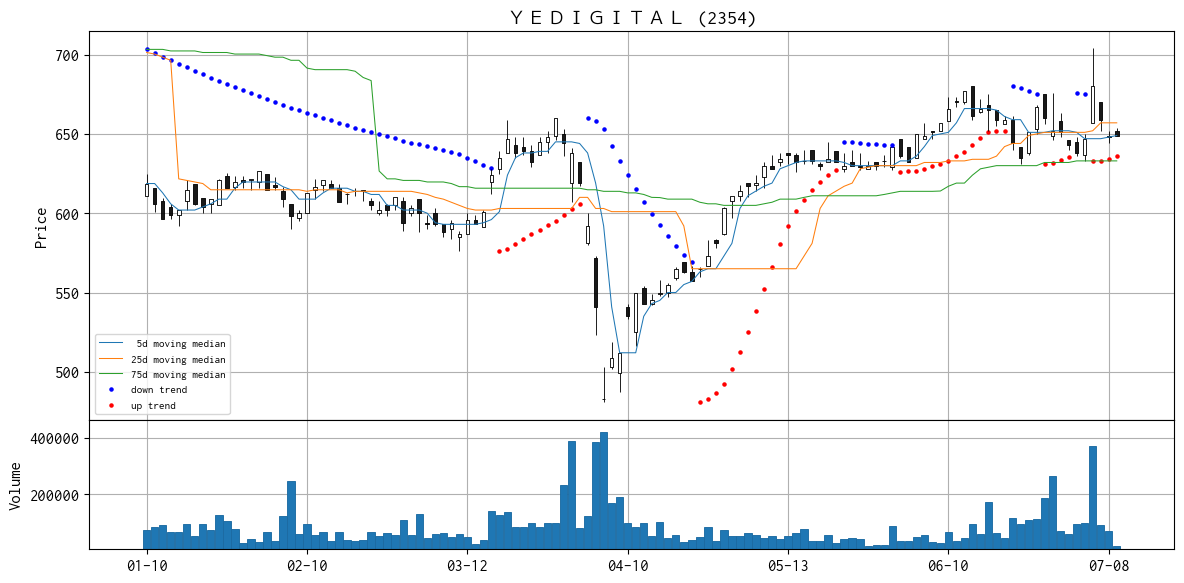

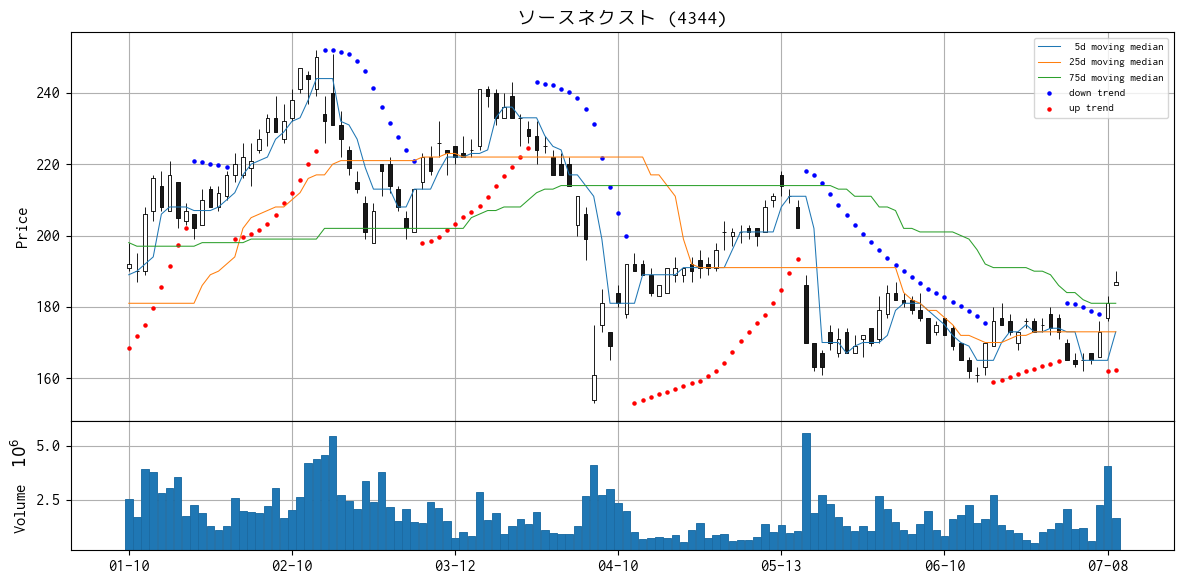

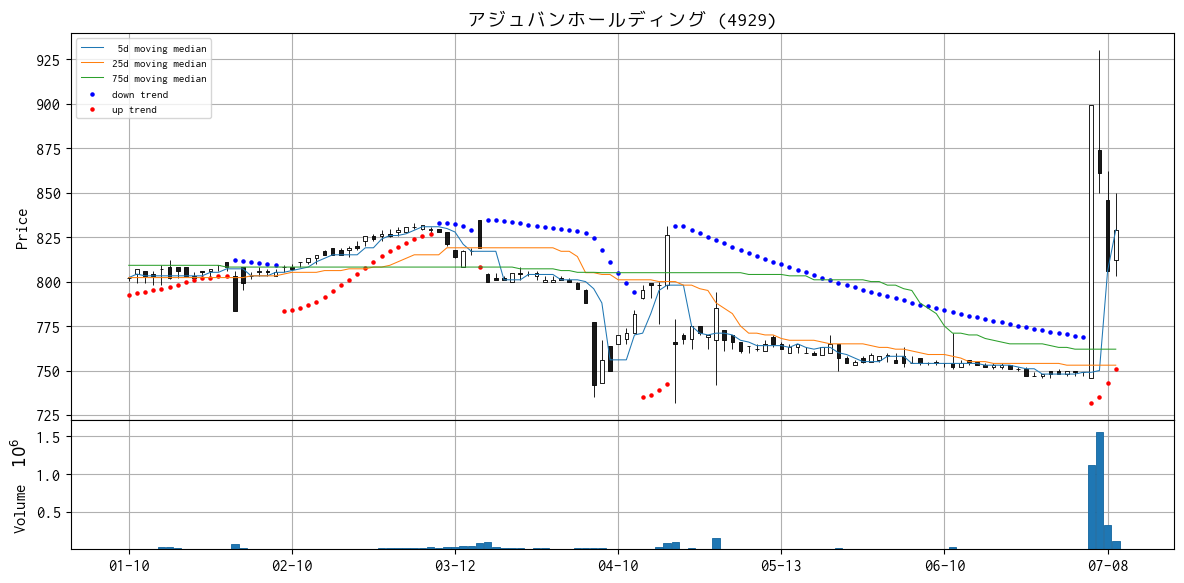

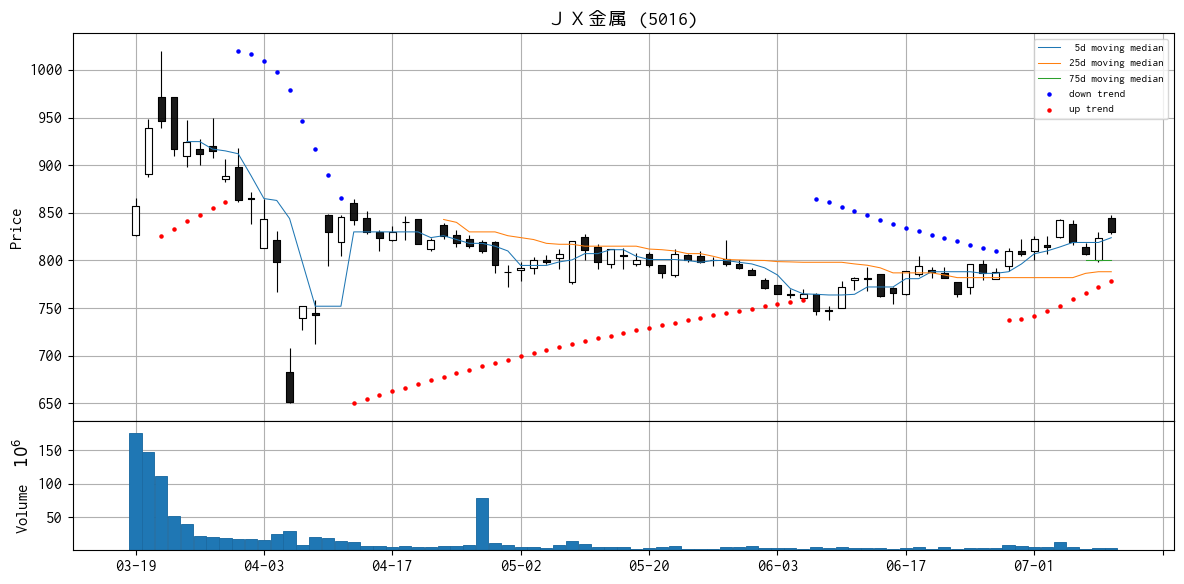

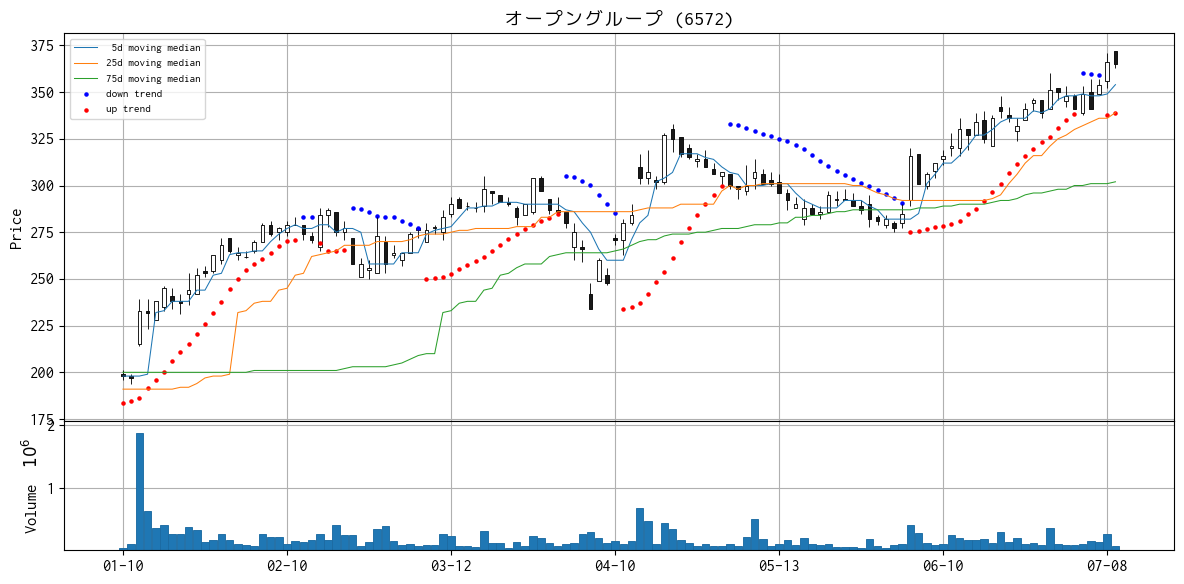

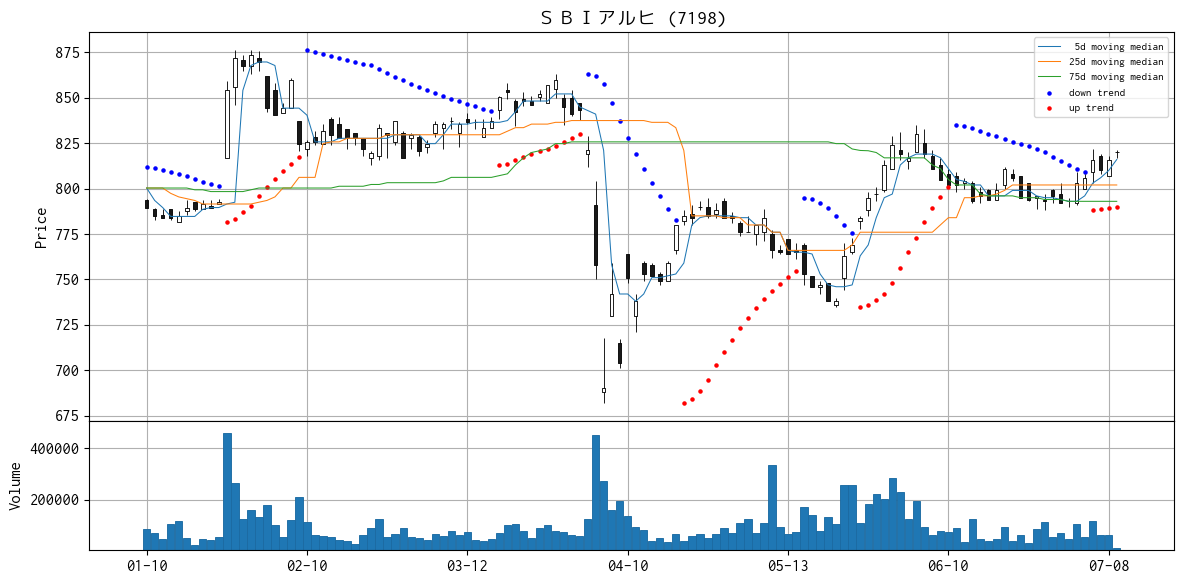

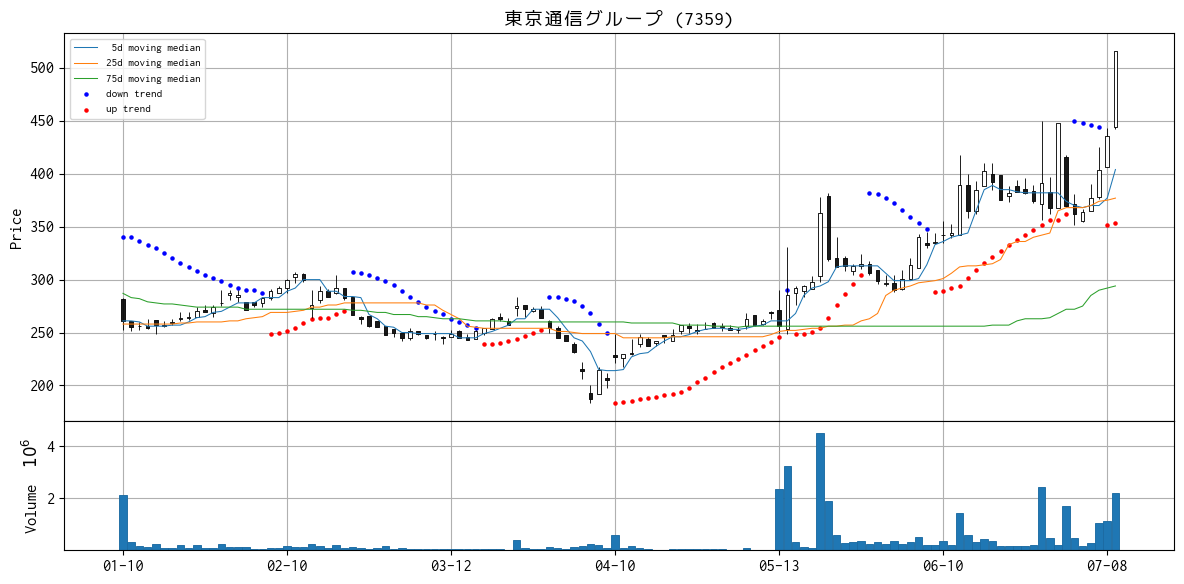

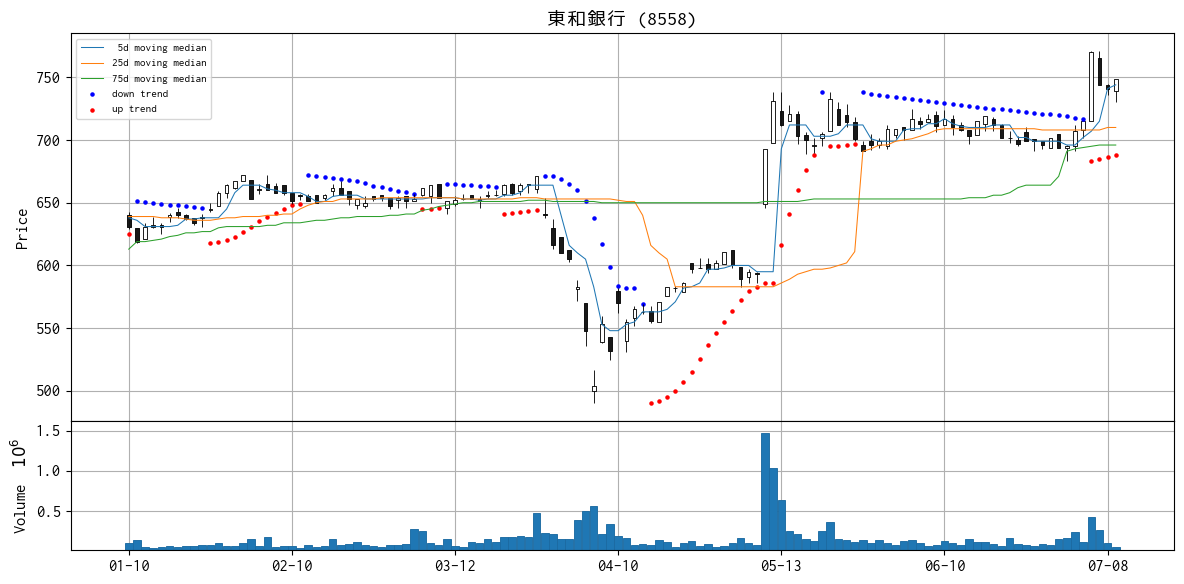

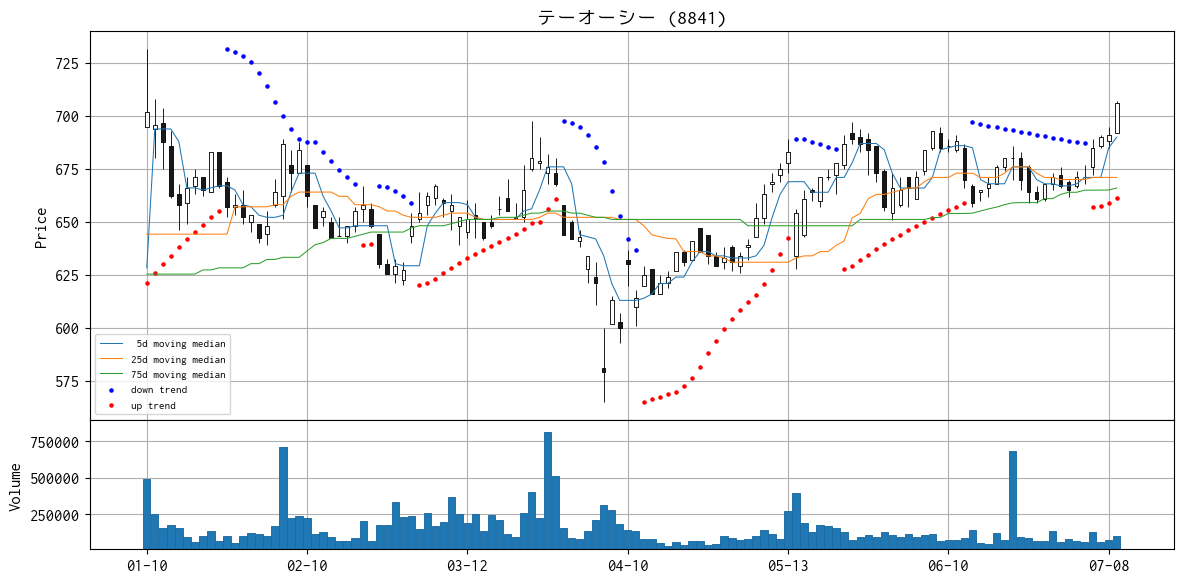

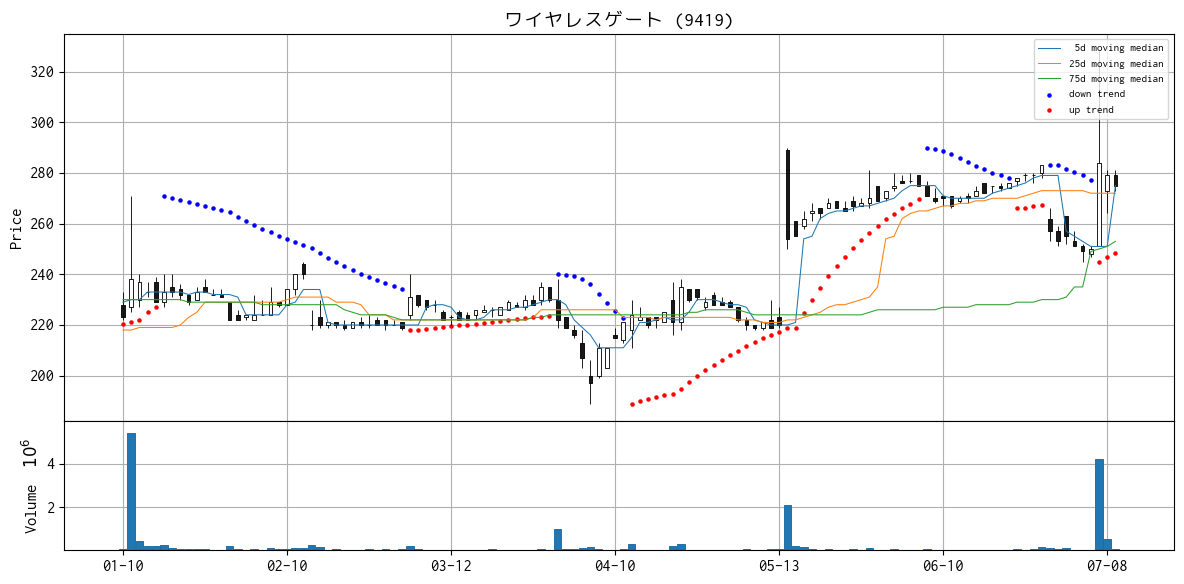

In [65]:
for r in range(len(df_portfolio)):
    code = df_portfolio.at[r, "銘柄コード "]
    if code == "--------":
        break
    name = df_portfolio.at[r, "銘柄名称"]
    symbol = f"{code}.T"
    ticker = yf.Ticker(symbol)
    df0 = ticker.history(period="3y", interval="1d")
    psar = ParabolicSAR()
    psar.calc(df0)

    # チャート
    dt_last = df0.index[len(df0) - 1]
    tdelta_1y = datetime.timedelta(days=180)
    df = df0[df0.index >= dt_last - tdelta_1y].copy()

    FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
    fm.fontManager.addfont(FONT_PATH)

    # FontPropertiesオブジェクト生成（名前の取得のため）
    font_prop = fm.FontProperties(fname=FONT_PATH)
    font_prop.get_name()

    plt.rcParams["font.family"] = font_prop.get_name()
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(12, 6))
    ax = dict()
    n = 2
    gs = fig.add_gridspec(
        n, 1, wspace=0.0, hspace=0.0, height_ratios=[3 if i == 0 else 1 for i in range(n)]
    )
    for i, axis in enumerate(gs.subplots(sharex="col")):
        ax[i] = axis
        ax[i].grid()

    mm05 = df0["Close"].rolling(5).median()
    mm25 = df0["Close"].rolling(25).median()
    mm75 = df0["Close"].rolling(75).median()

    apds = [
        mpf.make_addplot(mm05[df.index], width=0.75, label=" 5d moving median", ax=ax[0]),
        mpf.make_addplot(mm25[df.index], width=0.75, label="25d moving median", ax=ax[0]),
        mpf.make_addplot(mm75[df.index], width=0.75, label="75d moving median", ax=ax[0]),
        mpf.make_addplot(df["Bear"], type="scatter", marker="o", markersize=5, color="blue", label="down trend", ax=ax[0]),
        mpf.make_addplot(df["Bull"], type="scatter", marker="o", markersize=5, color="red", label="up trend", ax=ax[0]),
    ]
    mpf.plot(df, type="candle", style="default", volume=ax[1], datetime_format="%m-%d", addplot=apds, xrotation=0, ax=ax[0])
    ax[0].set_title(f"{name} ({code})")
    ax[0].legend(loc="best", fontsize=8)

    plt.tight_layout()
    plt.show()
    plt.close()